# Main process for E2 data analysis

Imports

In [2]:
import numpy as np
import NSFopen as ns
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy.fft as fft
from mpl_toolkits.axes_grid1 import make_axes_locatable

python(91200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Get directory information

In [3]:
current_dir = Path(os.getcwd())
parent_dir = current_dir.parent
data_folder = "/Users/thomashartigan/Library/CloudStorage/GoogleDrive-tjh200@cam.ac.uk/My Drive/E2/Images/Initial Testing/Setup A/" #parent_dir.as_posix() +'/Raw_Data/'

Create a class to analyse lattice constants

MultiIndex([(       'Tip',                    'Manufacturer'),
            (       'Tip',                            'Name'),
            (       'Tip',                           'Prop0'),
            (       'Tip',                           'Prop1'),
            (       'Tip',                           'Prop2'),
            (       'Tip',                           'Prop3'),
            (       'Tip',                           'Prop4'),
            (       'Tip',                           'Prop5'),
            (       'Tip',                           'Prop6'),
            (       'Tip',                           'Prop7'),
            (       'Tip',                           'Prop8'),
            (       'Tip',                           'Prop9'),
            (       'Tip',                          'Prop10'),
            (       'Tip',                          'Prop11'),
            (       'Tip',                          'Prop12'),
            (       'Tip',                          'Pr

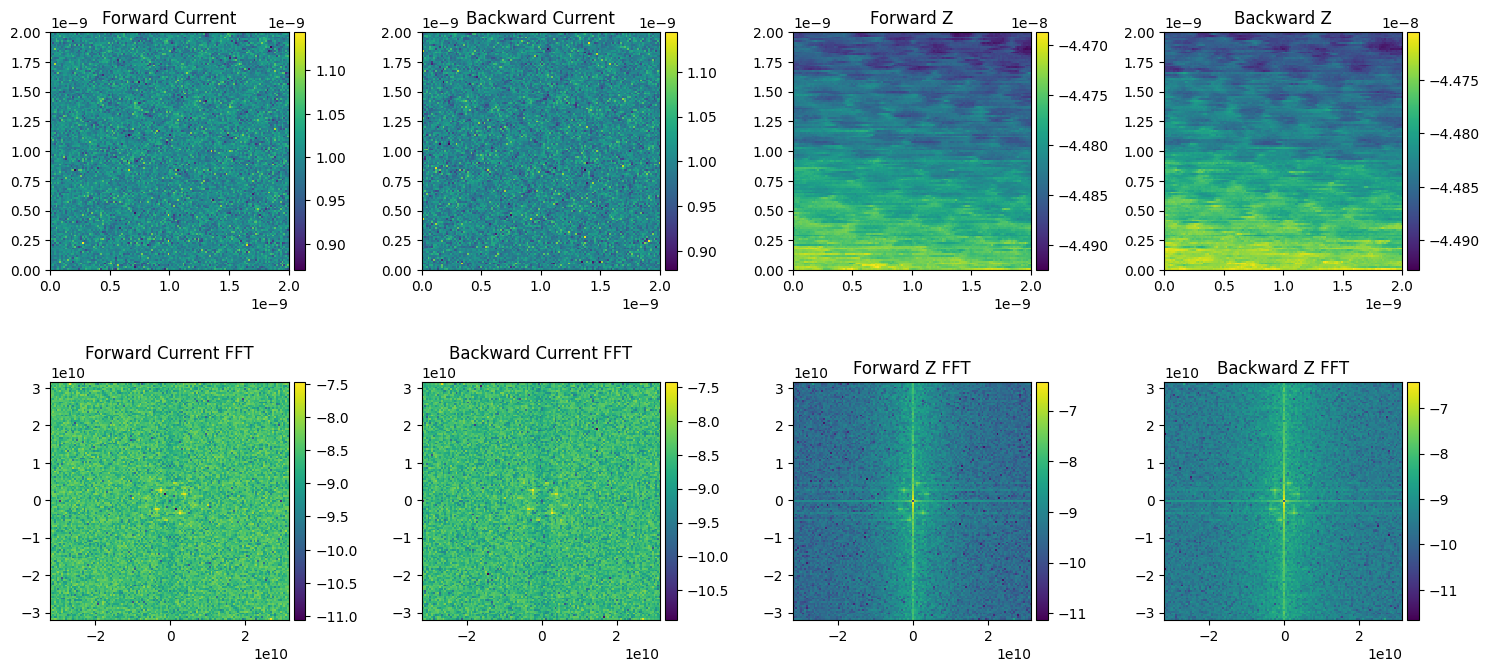

In [5]:
class Data_Image():
    def __init__(self, image_number):
        data_folder = "/Users/thomashartigan/Library/CloudStorage/GoogleDrive-tjh200@cam.ac.uk/My Drive/E2/Images/Initial Testing/Setup A/"
        self.image_path = data_folder + "Image" + image_number + ".nid"
        self.import_data()
    
    def import_data(self):
        afm = ns.read(self.image_path)
        data = afm.data # raw data
        param = afm.param # parameters
        self.params = param
        self.size = self.params['Scan']['range']['Value'][0]
        #print(data.keys())
        print(param.keys())
        self.forward_current = data['Image']['Forward']['Tip Current']
        self.forward_current_frequencies, self.forward_current_fft = self.fft_data(self.forward_current)
        self.backward_current = data['Image']['Backward']['Tip Current']
        self.backward_current_frequencies, self.backward_current_fft = self.fft_data(self.backward_current)
        self.forward_z = data['Image']['Forward']['Z-Axis']
        self.forward_z_frequencies, self.forward_z_fft = self.fft_data(self.forward_z)
        self.backward_z = data['Image']['Backward']['Z-Axis']
        self.backward_z_frequencies, self.backward_z_fft = self.fft_data(self.backward_z)
        
        print(self.size)

    def fft_data(self, dataset):
        dataset_fft = fft.fft2(dataset)
        n = len(dataset[0]) # Assuming a square dataset
        step_length = self.size/n
        freq = np.fft.fftfreq(n, d = step_length)
        shifted_freqs = fft.fftshift(dataset_fft)
        cleaned_shifted_freqs = self.clean_fft_data(shifted_freqs)
        return(freq, cleaned_shifted_freqs)
        
    def clean_fft_data(self, shifted_fft_data):
        #Remove 0 frequency component (should use even numbers of datapoints in rows)
        n = len(shifted_fft_data[0])
        target_n = int(n/2)
        shifted_fft_data[target_n][target_n] = 1E-10
        #shifted_fft_data[shifted_fft_data < 1E-9] = 1E-9
        return shifted_fft_data


    def plot_image_and_ffts(self):
        real_space_length = self.size
        im = [[None, None, None, None],[None, None, None, None]]

        fig, axs = plt.subplots(2, 4, figsize=(15,7))
        im[0][0] = axs[0,0].imshow(self.forward_current, interpolation = 'none', extent=[0, real_space_length, 0, real_space_length], aspect=1)
        axs[0,0].set_title('Forward Current')

        im[0][1] = axs[0,1].imshow(self.backward_current, interpolation = 'none', extent=[0, real_space_length, 0, real_space_length], aspect=1)
        axs[0,1].set_title('Backward Current')

        im[0][2] = axs[0,2].imshow(self.forward_z, interpolation = 'none', extent=[0, real_space_length, 0, real_space_length], aspect=1)
        axs[0,2].set_title('Forward Z')

        im[0][3] = axs[0,3].imshow(self.backward_z, interpolation = 'none', extent=[0, real_space_length, 0, real_space_length], aspect=1)
        axs[0,3].set_title('Backward Z')

        im[1][0] = axs[1,0].imshow(np.log10(abs(self.forward_current_fft)), interpolation = 'none', extent=[min(self.forward_current_frequencies), max(self.forward_current_frequencies), min(self.forward_current_frequencies), max(self.forward_current_frequencies)], aspect=1)
        axs[1,0].set_title('Forward Current FFT')

        im[1][1] = axs[1,1].imshow(np.log10(abs(self.backward_current_fft)), interpolation = 'none', extent=[min(self.backward_current_frequencies), max(self.backward_current_frequencies), min(self.backward_current_frequencies), max(self.backward_current_frequencies)], aspect=1)
        axs[1,1].set_title('Backward Current FFT')

        im[1][2] = axs[1,2].imshow(np.log10(abs(self.forward_z_fft)), interpolation = 'none', extent=[min(self.forward_z_frequencies), max(self.forward_z_frequencies), min(self.forward_z_frequencies), max(self.forward_z_frequencies)], aspect=1)
        axs[1,2].set_title('Forward Z FFT')

        im[1][3] = axs[1,3].imshow(np.log10(abs(self.backward_z_fft)), interpolation = 'none', extent=[min(self.backward_z_frequencies), max(self.backward_z_frequencies), min(self.backward_z_frequencies), max(self.backward_z_frequencies)], aspect=1)
        axs[1,3].set_title('Backward Z FFT')

        for i in range(0,2):
            for j in range(0,4):
                divider = make_axes_locatable(axs[i,j])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im[i][j], cax=cax, orientation='vertical')
        fig.tight_layout()

#04782
image_of_interest = Data_Image("05085")
image_of_interest.plot_image_and_ffts()
print(image_of_interest.params['Scan']['rotation'])